## Demo 1: Run a DNN on an accelerator, get energy and latency breakdown

In this demo, we show how to use ZigZag API function to obtain the energy/latency/EDP of running a DNN on an accelerator (with the best mapping found by ZigZag).

### 1) Explain the API function

```
energy, latency, cme = get_hardware_performance_zigzag(workload,
                                                       accelerator,
                                                       mapping,
                                                       opt='latency',
                                                       dump_filename_pattern="outputs/{datetime}.json",
                                                       pickle_filename="outputs/list_of_cmes.pickle"):
```
##### Inputs to the function
- **workload**: A neural network model defined in ONNX format or ZigZag's own format. (It can be the path to the model or the model itself.
- **accelerator**: A high-level HW architecture description.
- **mapping**: A file that specifies core allocation, spatial mapping (optional), temporal ordering (optional), and memory operand link.
*Note: workload (in zigzag's own format), accelerator, mapping can be the path to the module or the module itself; workload (in onnx format) should be the path to the file.*
- **opt**: Optimization target. It can be 'energy', 'latency', or 'EDP'.
- **dump_filename_pattern**: The name of the result file.
- **pickle_filename**: The name of the file which includes all the detailed metadata for analysing and debugging.

##### Output of the function
- **energy**: A number that indicates the overall consumed energy for running the workload on the accelerator in the user-defined optimized way.
- **latency**: A number that indicates the overall latency (cycle count) for running the workload on the accelerator in the user-defined optimized way.
- **cme**: A collection of all the detailed cost model evaluation results. "cme" stands for "cost model evaluation".



### 2) Prepare the inputs

In [1]:
# Get the workload

# workload 1 (onnx model)
model = "alexnet"
onnx_model_path = f"{model}.onnx"
workload = onnx_model_path

# workload 2 (onnx model)
# model = "mobilenetv2"  # uncomment these 3 lines to try the second workload
# onnx_model_path = f"{model}.onnx"
# workload = onnx_model_path

# workload 3 (self-defined model)
# model = "resnet18"  # uncomment these 2 lines to try the third workload
# workload = f"zigzag.inputs.examples.workload.{model}"

In [2]:
# Get the accelerator and mapping
mapping = "zigzag.inputs.examples.mapping.edge_tpu_like"
accelerator = "zigzag.inputs.examples.hardware.Edge_TPU_like"

# Set the filenames
dump_filename_pattern=f"outputs/Edge_TPU-{model}-layer_?.json"
pickle_filename = f"outputs/Edge_TPU-{model}-saved_list_of_cmes.pickle"

### 3) Run ZigZag API function

In [3]:
from zigzag.api import get_hardware_performance_zigzag

energy, latency, cme = get_hardware_performance_zigzag(workload=workload,
                                                       accelerator=accelerator,
                                                       mapping=mapping,
                                                       opt='energy',
                                                       dump_filename_pattern=dump_filename_pattern,
                                                       pickle_filename=pickle_filename)

2023-02-09 12:31:18,127 - generate_layer_node_for_conv +175 - INFO - Parsed Conv node 
2023-02-09 12:31:18,130 - generate_layer_node_for_conv +175 - INFO - Parsed Conv node 
2023-02-09 12:31:18,132 - generate_layer_node_for_conv +175 - INFO - Parsed Conv node 
2023-02-09 12:31:18,133 - generate_layer_node_for_conv +175 - INFO - Parsed Conv node 
2023-02-09 12:31:18,135 - generate_layer_node_for_conv +175 - INFO - Parsed Conv node 
2023-02-09 12:31:18,137 - generate_layer_node_for_gemm +112 - INFO - Parsed Gemm node 
2023-02-09 12:31:18,138 - generate_layer_node_for_gemm +112 - INFO - Parsed Gemm node 
2023-02-09 12:31:18,139 - generate_layer_node_for_gemm +112 - INFO - Parsed Gemm node 
2023-02-09 12:31:18,140 - parse_workload_from_onnx_model_and_mapping +101 - INFO - Created ONNXWorkload graph with 24 nodes and 23 edges.
2023-02-09 12:31:18,149 - parse_accelerator_from_path +56 - INFO - Parsed accelerator with cores [1].
2023-02-09 12:31:18,150 - run +33 - INFO - Processing layer 0...

### 4) View the outputs

In [4]:
print(f"Total network energy = {energy:.2e} pJ")
print(f"Total network latency = {latency:.2e} cycles")

Total network energy = 5.66e+09 pJ
Total network latency = 8.35e+06 cycles


As logged during our ZigZag run, a list of 8 CMEs is saved to 'pickle_filename'. We load in this list and use the built-in visualization script to show an energy and latency breakdown for each of the layers. As the last fully connected layers are a clear bottleneck (you can verify this yourself by plotting all the CMEs instead of only the first 5), they are not plotted in this example.

#### 4.1) View energy and latency breakdown

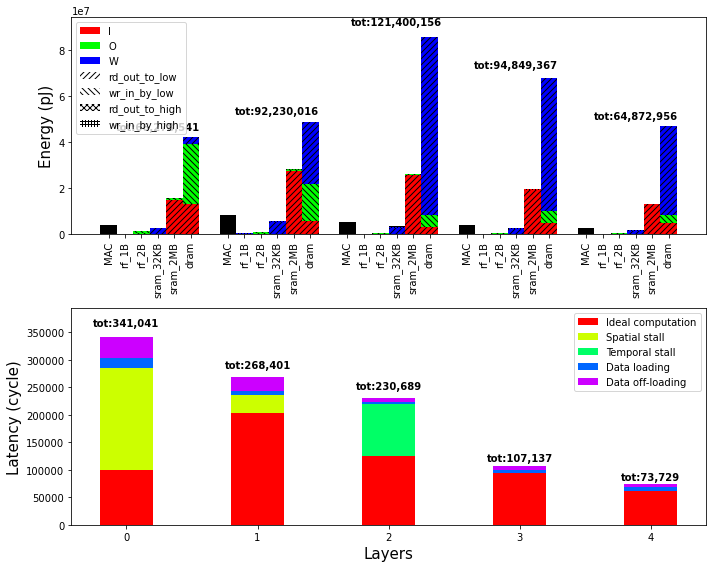

In [5]:
import pickle
from zigzag.visualization.results.plot_cme import bar_plot_cost_model_evaluations_breakdown

# Load in the pickled list of CMEs
with open(pickle_filename, 'rb') as fp:
    cme_for_all_layers = pickle.load(fp)

# Plot all the layers and save to 'plot_all.png'
bar_plot_cost_model_evaluations_breakdown(cme_for_all_layers[:5], save_path="plot_breakdown.png")  # plot for the first 5 layers
# bar_plot_cost_model_evaluations_breakdown(cme_for_all_layers, save_path="plot_breakdown.png")  # uncomment this line to plot for all the layers

As mentioned, this plot shows the different layers of AlexNet. It has two core components: the top one showing the energy breakdown, and the bottom one latency breakdown. 

Energy breakdown
: Different layer shapes have different activation sizes (I/O) and parameter sizes (W), which cause a varying number of memory accesses, depending on the layout of the memory hierarchy for each of these operands and the achievable reuse for each operand within each memory.

Latency breakdown
: Different aspects impact the latency. The spatial under-utilization of the array leads to "spatial stalls", where as insufficient memory bandwidth can lead to "temporal stalls".

#### 4.2) View temporal mappings of all the layers

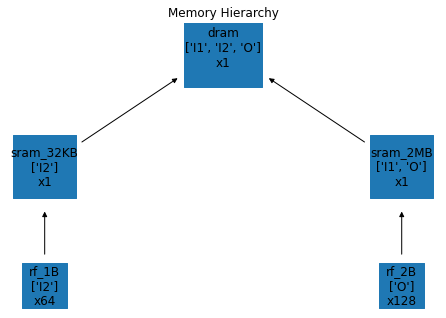


                                                                                     
********* Temporal Mapping - CostModelEvaluation(layer=LayerNode_0, core=1) *********
 O (O): [[('FX', 11), ('FY', 11)], [('OY', 7), ('OY', 2), ('OX', 14), ('K', 12)], []]
 W (I2): [[], [('FX', 11), ('FY', 11), ('OY', 7), ('OY', 2), ('OX', 14)], [('K', 12)]]
 I (I1): [[('FX', 11), ('FY', 11), ('OY', 7), ('OY', 2), ('OX', 14), ('K', 12)], []] 
                                                                                     
-------------------------------------------------------------------------------------
 Temporal Loops                  O                  W                  I             
-------------------------------------------------------------------------------------
 for K in [0:12)                 sram_2MB           dram               sram_2MB      
-------------------------------------------------------------------------------------
  for OX in [0:14)               sram_2MB           

In [6]:
from zigzag.visualization.results.print_mapping import print_mapping
from zigzag.visualization.graph.memory_hierarchy import visualize_memory_hierarchy_graph

visualize_memory_hierarchy_graph(cme_for_all_layers[0].accelerator.cores[0].memory_hierarchy)
for cme in cme_for_all_layers:
    print_mapping(cme)